## 9.3 Part A##

In [1]:
import numpy as np
import glob
import os

import bebi103
# A whole bunch of skimage stuff
import skimage.feature
import skimage.filters
import skimage.filters.rank
import skimage.io
import skimage.morphology
import skimage.restoration
import skimage.segmentation
import skimage.transform

# And some useful scipy.ndimage stuff
import scipy.ndimage

import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)
%matplotlib inline

Below is overview of what we are doing:

1) Load all images into three lists based on their prefix (snaps001, snaps002, or snaps003).

2) For each of the above lists, we divide up into 4 lists (one corresponding to each channel, c, p, r, and y)

3) For each set of images (001, 002, or 003), we calculate the mean intensities of the each bacterium in the CFP and YFP channels. (We will go through one image of each set to show how this happens)

4) We will also show a representative segmentation (one each for each set of images) by overlaying your binary segmented image on a phase image

In [3]:
my_dir = '../data/park_et_al/'
glob.glob(my_dir)

['../data/park_et_al/']

We get the files based on starting with "snaps001" or "snaps002" or "snaps003"

In [4]:
snaps1 = []
snaps2 = []
snaps3 = []
for fname in os.listdir(my_dir):
    if fname.startswith("snaps001"):
        snaps1.append(os.path.join(my_dir, fname))
    if fname.startswith("snaps002"):
        snaps2.append(os.path.join(my_dir, fname))
    if fname.startswith("snaps003"):
        snaps3.append(os.path.join(my_dir, fname))

<div class='alert alert-info'> 
You could also do this just by globbing and skipping the path joining.
</div> 

Now for each set of images, we divide up into 4 lists corresponding to the 4 channels. We do this for 001, 002, and 003

In [5]:
# We know that the 32 is the index of the character in the filename string that represents what channel it is in
snaps1C = []
snaps1P = []
snaps1R = []
snaps1Y = []
for i in snaps1:
    if i[32] == 'c':
        snaps1C.append(i)
    elif i[32] == 'p':
        snaps1P.append(i)
    elif i[32] == 'r':
        snaps1R.append(i)
    elif i[32] == 'y':
        snaps1Y.append(i)

In [6]:
snaps2C = []
snaps2P = []
snaps2R = []
snaps2Y = []

for i in snaps2:
    if i[32] == 'c':
        snaps2C.append(i)
    elif i[32] == 'p':
        snaps2P.append(i)
    elif i[32] == 'r':
        snaps2R.append(i)
    elif i[32] == 'y':
        snaps2Y.append(i)

In [7]:
def zero_crossing_filter(im, thresh):
    """
    Returns image with 1 if there is a zero crossing and 0 otherwise.
    
    thresh is the the minimal value of the gradient, as computed by Sobel
    filter, at crossing to count as a crossing.
    """
    # Square structuring element
    selem = skimage.morphology.square(3)
    
    # Do max filter and min filter
    im_max = scipy.ndimage.filters.maximum_filter(im, footprint=selem)
    im_min = scipy.ndimage.filters.minimum_filter(im, footprint=selem)
    
    # Compute gradients using Sobel filter
    im_grad = skimage.filters.sobel(im)
    
    # Return edges
    return (((im >= 0) & (im_min < 0)) | ((im <= 0) & (im_max > 0))) \
                & (im_grad >= thresh)

In [8]:
snaps3C = []
snaps3P = []
snaps3R = []
snaps3Y = []

for i in snaps3:
    if i[32] == 'c':
        snaps3C.append(i)
    elif i[32] == 'p':
        snaps3P.append(i)
    elif i[32] == 'r':
        snaps3R.append(i)
    elif i[32] == 'y':
        snaps3Y.append(i)

Now we get the mean intensities of each bacterium for all images in set 001. 

In [9]:
intensityCsnaps1 = []
intensityYsnaps1 = []
for i in range(len(snaps1R)): 
    tempC = []
    tempY = []
    im = skimage.io.imread(snaps1R[i])
    im_c = skimage.io.imread(snaps1C[i])
    im_p = skimage.io.imread(snaps1P[i])
    im_y = skimage.io.imread(snaps1Y[i])
    
    im_p = scipy.ndimage.zoom(im_p, 2, order=0)
    im_c = scipy.ndimage.zoom(im_c, 2, order=0)
    im_y = scipy.ndimage.zoom(im_y, 2, order=0)

    im_float = (im.astype(float) - im.min()) / (im.max() - im.min())
    im_edge = skimage.feature.canny(im_float, 1.4)
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)
    # Close the edge image
    selem = skimage.morphology.disk(2)
    im_edge_closed = skimage.morphology.binary_closing(im_edge, selem)

    # Fill these holes
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge_closed)
    im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float, 2.0)
    # 3x3 square structuring element
    selem = skimage.morphology.square(3)
    
    # Do max filter and min filter
    im_LoG_max = scipy.ndimage.filters.maximum_filter(im_LoG, footprint=selem)
    im_LoG_min = scipy.ndimage.filters.minimum_filter(im_LoG, footprint=selem)

    # Image of zero-crossings
    im_edge = ((im_LoG >= 0) & (im_LoG_min < 0)) \
        | ((im_LoG <= 0) & (im_LoG_max > 0))
    im_edge = zero_crossing_filter(im_LoG, 0.001)
    im_edge = skimage.morphology.skeletonize(im_edge)
    # Fill holes
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)

    # Remove small objectes that are not bacteria
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=100)

    im_bw = skimage.segmentation.clear_border(im_bw, buffer_size=5)
    im_labeled, n_labels = skimage.measure.label(
                            im_bw, background=0, return_num=True)
    
    im_c_props = skimage.measure.regionprops(im_labeled, intensity_image=im_c)
    im_y_props = skimage.measure.regionprops(im_labeled, intensity_image=im_y)
    # Loop through properties and print area and mean intensity in CFP channel
    for prop in im_c_props:
        tempC.append(int(prop.mean_intensity))
    for prop in im_y_props:
        tempY.append(int(prop.mean_intensity))
    intensityCsnaps1.append(tempC)
    intensityYsnaps1.append(tempY)


In [10]:
print(intensityCsnaps1)

[[716, 841, 541, 956, 576, 627, 620, 749, 985, 784, 691, 838, 688, 938, 877, 852, 981, 1014, 711, 877, 1093, 648, 918, 599, 935, 846, 590, 848, 672, 860, 688, 763, 671, 485, 665, 584, 580, 617, 562, 694, 781, 871, 750, 623, 680, 564, 646, 596, 895, 634, 592, 996, 802, 743, 514, 818, 663, 624, 735, 531, 706, 710, 666, 753, 611, 1242, 739, 1209, 688, 748, 718, 686, 641, 709, 656, 713, 611, 646, 775, 590, 533, 638, 529, 653, 829, 759, 571, 644, 580, 883, 721, 800], [746, 862, 595, 790, 843, 846, 698, 920, 823, 612, 690, 538, 896, 701, 551, 716, 834, 662, 685, 899, 688, 523, 918, 824, 957, 699, 987, 624, 672, 650, 781, 803, 833, 544, 697, 789, 699, 570, 802, 753, 677, 1008, 794, 561, 1159, 596, 718, 789, 547, 798, 682, 757, 645, 833, 693, 505, 569, 616, 647, 686, 684, 648, 671, 534, 641, 748, 663, 857, 906, 497, 992, 788, 781, 1003, 753, 726, 877, 999, 659, 1486, 505, 495, 499], [934, 697, 694, 608, 802, 831, 746, 658, 851, 681, 768, 772, 674, 768, 781, 736, 771, 810, 779, 1223, 740, 866, 

As described above, this stores the intensities of all bacteria for each image of the 001 set. Now let's visually show one image of the 001 set and the mean intensities for each labeled bacteria.

In [11]:
for i in range(1): 
    tempC = []
    tempY = []
    im = skimage.io.imread(snaps1R[i])
    im_c = skimage.io.imread(snaps1C[i])
    im_p = skimage.io.imread(snaps1P[i])
    im_y = skimage.io.imread(snaps1Y[i])
    
    im_p = scipy.ndimage.zoom(im_p, 2, order=0)
    im_c = scipy.ndimage.zoom(im_c, 2, order=0)
    im_y = scipy.ndimage.zoom(im_y, 2, order=0)

    im_float = (im.astype(float) - im.min()) / (im.max() - im.min())
    im_edge = skimage.feature.canny(im_float, 1.4)
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)
    # Close the edge image
    selem = skimage.morphology.disk(2)
    im_edge_closed = skimage.morphology.binary_closing(im_edge, selem)

    # Fill these holes
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge_closed)
    im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float, 2.0)
    # 3x3 square structuring element
    selem = skimage.morphology.square(3)
    
    # Do max filter and min filter
    im_LoG_max = scipy.ndimage.filters.maximum_filter(im_LoG, footprint=selem)
    im_LoG_min = scipy.ndimage.filters.minimum_filter(im_LoG, footprint=selem)

    # Image of zero-crossings
    im_edge = ((im_LoG >= 0) & (im_LoG_min < 0)) \
        | ((im_LoG <= 0) & (im_LoG_max > 0))
    im_edge = zero_crossing_filter(im_LoG, 0.001)
    im_edge = skimage.morphology.skeletonize(im_edge)
    # Fill holes
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)

    # Remove small objectes that are not bacteria
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=100)

    im_bw = skimage.segmentation.clear_border(im_bw, buffer_size=5)
    im_labeled, n_labels = skimage.measure.label(
                            im_bw, background=0, return_num=True)
    
    im_c_props = skimage.measure.regionprops(im_labeled, intensity_image=im_c)
    im_y_props = skimage.measure.regionprops(im_labeled, intensity_image=im_y)


Number of individual bacteria =  91


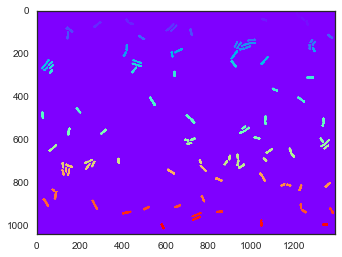

In [12]:
with sns.axes_style('white'):
    plt.imshow(im_labeled, cmap=plt.cm.rainbow)

# Show number of bacteria
print('Number of individual bacteria = ', n_labels - 1)

In [13]:
for i in range(len(intensityCsnaps1[0])):
    print("Bacteria " + str(i) + ": Mean CFP Intensity = " + str(intensityCsnaps1[0][i]) + ": Mean YFP Intensity = " + str(intensityYsnaps1[0][i])  )

Bacteria 0: Mean CFP Intensity = 716: Mean YFP Intensity = 1161
Bacteria 1: Mean CFP Intensity = 841: Mean YFP Intensity = 1118
Bacteria 2: Mean CFP Intensity = 541: Mean YFP Intensity = 630
Bacteria 3: Mean CFP Intensity = 956: Mean YFP Intensity = 1838
Bacteria 4: Mean CFP Intensity = 576: Mean YFP Intensity = 1432
Bacteria 5: Mean CFP Intensity = 627: Mean YFP Intensity = 1780
Bacteria 6: Mean CFP Intensity = 620: Mean YFP Intensity = 2316
Bacteria 7: Mean CFP Intensity = 749: Mean YFP Intensity = 1532
Bacteria 8: Mean CFP Intensity = 985: Mean YFP Intensity = 731
Bacteria 9: Mean CFP Intensity = 784: Mean YFP Intensity = 1760
Bacteria 10: Mean CFP Intensity = 691: Mean YFP Intensity = 1429
Bacteria 11: Mean CFP Intensity = 838: Mean YFP Intensity = 1492
Bacteria 12: Mean CFP Intensity = 688: Mean YFP Intensity = 2341
Bacteria 13: Mean CFP Intensity = 938: Mean YFP Intensity = 2281
Bacteria 14: Mean CFP Intensity = 877: Mean YFP Intensity = 1965
Bacteria 15: Mean CFP Intensity = 852

These are the mean CFP and YFP intensities for each bacteria of an image in set 001. We can also plot it.

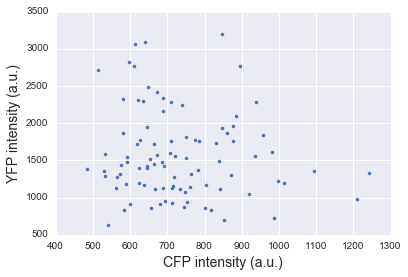

In [14]:
mean_c_intensity = np.empty(len(im_c_props))
mean_y_intensity = np.empty(len(im_y_props))
for i in range(len(im_c_props)):
    mean_c_intensity[i] = im_c_props[i].mean_intensity
    mean_y_intensity[i] = im_y_props[i].mean_intensity

intensityC1 = mean_c_intensity
intensityY1 = mean_y_intensity
# Plot intensities
plt.plot(mean_c_intensity, mean_y_intensity, '.')
plt.xlabel('CFP intensity (a.u.)')
plt.ylabel('YFP intensity (a.u.)');

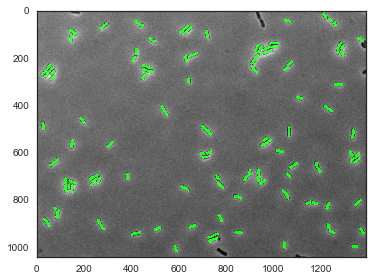

In [15]:
# Convert phase image to float RGB
im_p_float = (im_p - im_p.min()) / (im_p.max() - im_p.min())

# Make the green channel 1 wherever we have a bacterium
im_p_g = np.copy(im_p_float)
im_p_g[im_bw] = 1

# Build RGB image
im_p_rgb = np.dstack((im_p_float, im_p_g, im_p_float))

# Show result
with sns.axes_style('white'):
    skimage.io.imshow(im_p_rgb)


This is the representative segmentation for set 001. Now, let's repeat the process for set 002.

In [16]:
intensityCsnaps2 = []
intensityYsnaps2 = []
for i in range(len(snaps2R)): 
    tempC = []
    tempY = []
    im = skimage.io.imread(snaps2R[i])
    im_c = skimage.io.imread(snaps2C[i])
    im_p = skimage.io.imread(snaps2P[i])
    im_y = skimage.io.imread(snaps2Y[i])
    
    im_p = scipy.ndimage.zoom(im_p, 2, order=0)
    im_c = scipy.ndimage.zoom(im_c, 2, order=0)
    im_y = scipy.ndimage.zoom(im_y, 2, order=0)

    im_float = (im.astype(float) - im.min()) / (im.max() - im.min())
    im_edge = skimage.feature.canny(im_float, 1.4)
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)
    # Close the edge image
    selem = skimage.morphology.disk(2)
    im_edge_closed = skimage.morphology.binary_closing(im_edge, selem)

    # Fill these holes
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge_closed)
    im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float, 2.0)
    # 3x3 square structuring element
    selem = skimage.morphology.square(3)
    
    # Do max filter and min filter
    im_LoG_max = scipy.ndimage.filters.maximum_filter(im_LoG, footprint=selem)
    im_LoG_min = scipy.ndimage.filters.minimum_filter(im_LoG, footprint=selem)

    # Image of zero-crossings
    im_edge = ((im_LoG >= 0) & (im_LoG_min < 0)) \
        | ((im_LoG <= 0) & (im_LoG_max > 0))
    im_edge = zero_crossing_filter(im_LoG, 0.001)
    im_edge = skimage.morphology.skeletonize(im_edge)
    # Fill holes
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)

    # Remove small objectes that are not bacteria
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=100)

    im_bw = skimage.segmentation.clear_border(im_bw, buffer_size=5)
    im_labeled, n_labels = skimage.measure.label(
                            im_bw, background=0, return_num=True)
    
    im_c_props = skimage.measure.regionprops(im_labeled, intensity_image=im_c)
    im_y_props = skimage.measure.regionprops(im_labeled, intensity_image=im_y)
    # Loop through properties and print area and mean intensity in CFP channel
    for prop in im_c_props:
        tempC.append(int(prop.mean_intensity))
    for prop in im_y_props:
        tempY.append(int(prop.mean_intensity))
    intensityCsnaps2.append(tempC)
    intensityYsnaps2.append(tempY)


In [17]:
for i in range(1): 
    tempC = []
    tempY = []
    im = skimage.io.imread(snaps2R[i])
    im_c = skimage.io.imread(snaps2C[i])
    im_p = skimage.io.imread(snaps2P[i])
    im_y = skimage.io.imread(snaps2Y[i])
    
    im_p = scipy.ndimage.zoom(im_p, 2, order=0)
    im_c = scipy.ndimage.zoom(im_c, 2, order=0)
    im_y = scipy.ndimage.zoom(im_y, 2, order=0)

    im_float = (im.astype(float) - im.min()) / (im.max() - im.min())
    im_edge = skimage.feature.canny(im_float, 1.4)
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)
    # Close the edge image
    selem = skimage.morphology.disk(2)
    im_edge_closed = skimage.morphology.binary_closing(im_edge, selem)

    # Fill these holes
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge_closed)
    im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float, 2.0)
    # 3x3 square structuring element
    selem = skimage.morphology.square(3)
    
    # Do max filter and min filter
    im_LoG_max = scipy.ndimage.filters.maximum_filter(im_LoG, footprint=selem)
    im_LoG_min = scipy.ndimage.filters.minimum_filter(im_LoG, footprint=selem)

    # Image of zero-crossings
    im_edge = ((im_LoG >= 0) & (im_LoG_min < 0)) \
        | ((im_LoG <= 0) & (im_LoG_max > 0))
    im_edge = zero_crossing_filter(im_LoG, 0.001)
    im_edge = skimage.morphology.skeletonize(im_edge)
    # Fill holes
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)

    # Remove small objectes that are not bacteria
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=100)

    im_bw = skimage.segmentation.clear_border(im_bw, buffer_size=5)
    im_labeled, n_labels = skimage.measure.label(
                            im_bw, background=0, return_num=True)
    
    im_c_props = skimage.measure.regionprops(im_labeled, intensity_image=im_c)
    im_y_props = skimage.measure.regionprops(im_labeled, intensity_image=im_y)


Number of individual bacteria =  87


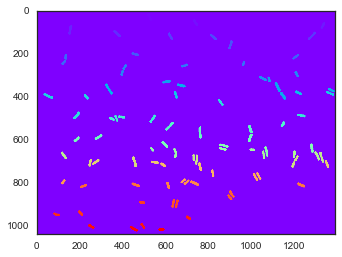

In [18]:
with sns.axes_style('white'):
    plt.imshow(im_labeled, cmap=plt.cm.rainbow)

# Show number of bacteria
print('Number of individual bacteria = ', n_labels - 1)

In [19]:
for i in range(len(intensityCsnaps2[0])):
    print("Bacteria " + str(i) + ": Mean CFP Intensity = " + str(intensityCsnaps2[0][i]) + ": Mean YFP Intensity = " + str(intensityYsnaps2[0][i])  )

Bacteria 0: Mean CFP Intensity = 1550: Mean YFP Intensity = 1619
Bacteria 1: Mean CFP Intensity = 893: Mean YFP Intensity = 886
Bacteria 2: Mean CFP Intensity = 2205: Mean YFP Intensity = 2684
Bacteria 3: Mean CFP Intensity = 1267: Mean YFP Intensity = 1596
Bacteria 4: Mean CFP Intensity = 980: Mean YFP Intensity = 1157
Bacteria 5: Mean CFP Intensity = 1705: Mean YFP Intensity = 1978
Bacteria 6: Mean CFP Intensity = 1713: Mean YFP Intensity = 2156
Bacteria 7: Mean CFP Intensity = 1013: Mean YFP Intensity = 1206
Bacteria 8: Mean CFP Intensity = 1398: Mean YFP Intensity = 1668
Bacteria 9: Mean CFP Intensity = 1965: Mean YFP Intensity = 2338
Bacteria 10: Mean CFP Intensity = 2059: Mean YFP Intensity = 2368
Bacteria 11: Mean CFP Intensity = 1079: Mean YFP Intensity = 1251
Bacteria 12: Mean CFP Intensity = 991: Mean YFP Intensity = 1029
Bacteria 13: Mean CFP Intensity = 1683: Mean YFP Intensity = 2147
Bacteria 14: Mean CFP Intensity = 1189: Mean YFP Intensity = 1388
Bacteria 15: Mean CFP In

These are the mean CFP and YFP intensities for each bacteria of an image in set 002. We can also plot it.

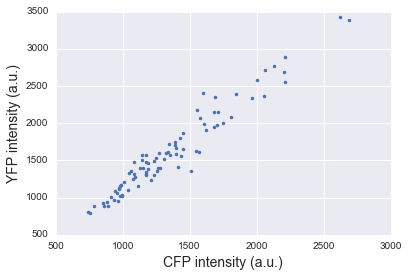

In [20]:
mean_c_intensity = np.empty(len(im_c_props))
mean_y_intensity = np.empty(len(im_y_props))
for i in range(len(im_c_props)):
    mean_c_intensity[i] = im_c_props[i].mean_intensity
    mean_y_intensity[i] = im_y_props[i].mean_intensity

intensityC2 = mean_c_intensity
intensityY2 = mean_y_intensity
# Plot intensities
plt.plot(mean_c_intensity, mean_y_intensity, '.')
plt.xlabel('CFP intensity (a.u.)')
plt.ylabel('YFP intensity (a.u.)');

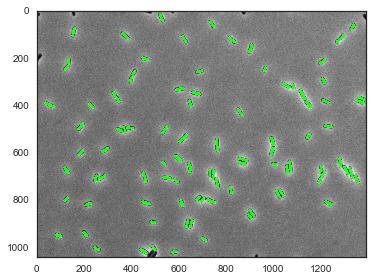

In [21]:
# Convert phase image to float RGB
im_p_float = (im_p - im_p.min()) / (im_p.max() - im_p.min())

# Make the green channel 1 wherever we have a bacterium
im_p_g = np.copy(im_p_float)
im_p_g[im_bw] = 1

# Build RGB image
im_p_rgb = np.dstack((im_p_float, im_p_g, im_p_float))

# Show result
with sns.axes_style('white'):
    skimage.io.imshow(im_p_rgb)


This is the representative segmentation for set 002. Now, let's repeat the process one more time for set 003.

In [22]:
intensityCsnaps3 = []
intensityYsnaps3 = []
for i in range(len(snaps3R)): 
    tempC = []
    tempY = []
    im = skimage.io.imread(snaps3R[i])
    im_c = skimage.io.imread(snaps3C[i])
    im_p = skimage.io.imread(snaps3P[i])
    im_y = skimage.io.imread(snaps3Y[i])
    
    im_p = scipy.ndimage.zoom(im_p, 2, order=0)
    im_c = scipy.ndimage.zoom(im_c, 2, order=0)
    im_y = scipy.ndimage.zoom(im_y, 2, order=0)

    im_float = (im.astype(float) - im.min()) / (im.max() - im.min())
    im_edge = skimage.feature.canny(im_float, 1.4)
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)
    # Close the edge image
    selem = skimage.morphology.disk(2)
    im_edge_closed = skimage.morphology.binary_closing(im_edge, selem)

    # Fill these holes
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge_closed)
    im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float, 2.0)
    # 3x3 square structuring element
    selem = skimage.morphology.square(3)
    
    # Do max filter and min filter
    im_LoG_max = scipy.ndimage.filters.maximum_filter(im_LoG, footprint=selem)
    im_LoG_min = scipy.ndimage.filters.minimum_filter(im_LoG, footprint=selem)

    # Image of zero-crossings
    im_edge = ((im_LoG >= 0) & (im_LoG_min < 0)) \
        | ((im_LoG <= 0) & (im_LoG_max > 0))
    im_edge = zero_crossing_filter(im_LoG, 0.001)
    im_edge = skimage.morphology.skeletonize(im_edge)
    # Fill holes
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)

    # Remove small objectes that are not bacteria
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=100)

    im_bw = skimage.segmentation.clear_border(im_bw, buffer_size=5)
    im_labeled, n_labels = skimage.measure.label(
                            im_bw, background=0, return_num=True)
    
    im_c_props = skimage.measure.regionprops(im_labeled, intensity_image=im_c)
    im_y_props = skimage.measure.regionprops(im_labeled, intensity_image=im_y)
    # Loop through properties and print area and mean intensity in CFP channel
    for prop in im_c_props:
        tempC.append(int(prop.mean_intensity))
    for prop in im_y_props:
        tempY.append(int(prop.mean_intensity))
    intensityCsnaps3.append(tempC)
    intensityYsnaps3.append(tempY)


In [23]:
for i in range(1): 
    tempC = []
    tempY = []
    im = skimage.io.imread(snaps3R[i])
    im_c = skimage.io.imread(snaps3C[i])
    im_p = skimage.io.imread(snaps3P[i])
    im_y = skimage.io.imread(snaps3Y[i])
    
    im_p = scipy.ndimage.zoom(im_p, 2, order=0)
    im_c = scipy.ndimage.zoom(im_c, 2, order=0)
    im_y = scipy.ndimage.zoom(im_y, 2, order=0)

    im_float = (im.astype(float) - im.min()) / (im.max() - im.min())
    im_edge = skimage.feature.canny(im_float, 1.4)
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)
    # Close the edge image
    selem = skimage.morphology.disk(2)
    im_edge_closed = skimage.morphology.binary_closing(im_edge, selem)

    # Fill these holes
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge_closed)
    im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float, 2.0)
    # 3x3 square structuring element
    selem = skimage.morphology.square(3)
    
    # Do max filter and min filter
    im_LoG_max = scipy.ndimage.filters.maximum_filter(im_LoG, footprint=selem)
    im_LoG_min = scipy.ndimage.filters.minimum_filter(im_LoG, footprint=selem)

    # Image of zero-crossings
    im_edge = ((im_LoG >= 0) & (im_LoG_min < 0)) \
        | ((im_LoG <= 0) & (im_LoG_max > 0))
    im_edge = zero_crossing_filter(im_LoG, 0.001)
    im_edge = skimage.morphology.skeletonize(im_edge)
    # Fill holes
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)

    # Remove small objectes that are not bacteria
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=100)

    im_bw = skimage.segmentation.clear_border(im_bw, buffer_size=5)
    im_labeled, n_labels = skimage.measure.label(
                            im_bw, background=0, return_num=True)
    
    im_c_props = skimage.measure.regionprops(im_labeled, intensity_image=im_c)
    im_y_props = skimage.measure.regionprops(im_labeled, intensity_image=im_y)


Number of individual bacteria =  47


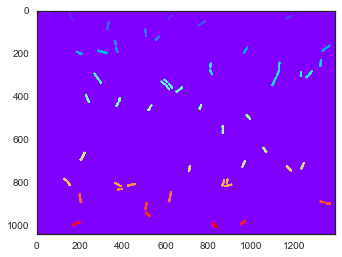

In [24]:
with sns.axes_style('white'):
    plt.imshow(im_labeled, cmap=plt.cm.rainbow)

# Show number of bacteria
print('Number of individual bacteria = ', n_labels - 1)

In [25]:
for i in range(len(intensityCsnaps3[0])):
    print("Bacteria " + str(i) + ": Mean CFP Intensity = " + str(intensityCsnaps3[0][i]) + ": Mean YFP Intensity = " + str(intensityYsnaps1[0][i])  )

Bacteria 0: Mean CFP Intensity = 703: Mean YFP Intensity = 1161
Bacteria 1: Mean CFP Intensity = 783: Mean YFP Intensity = 1118
Bacteria 2: Mean CFP Intensity = 1002: Mean YFP Intensity = 630
Bacteria 3: Mean CFP Intensity = 906: Mean YFP Intensity = 1838
Bacteria 4: Mean CFP Intensity = 1188: Mean YFP Intensity = 1432
Bacteria 5: Mean CFP Intensity = 575: Mean YFP Intensity = 1780
Bacteria 6: Mean CFP Intensity = 836: Mean YFP Intensity = 2316
Bacteria 7: Mean CFP Intensity = 962: Mean YFP Intensity = 1532
Bacteria 8: Mean CFP Intensity = 1067: Mean YFP Intensity = 731
Bacteria 9: Mean CFP Intensity = 821: Mean YFP Intensity = 1760
Bacteria 10: Mean CFP Intensity = 1023: Mean YFP Intensity = 1429
Bacteria 11: Mean CFP Intensity = 1337: Mean YFP Intensity = 1492
Bacteria 12: Mean CFP Intensity = 859: Mean YFP Intensity = 2341
Bacteria 13: Mean CFP Intensity = 707: Mean YFP Intensity = 2281
Bacteria 14: Mean CFP Intensity = 1216: Mean YFP Intensity = 1965
Bacteria 15: Mean CFP Intensity

These are the mean CFP and YFP intensities for each bacteria of an image in set 003. We can also plot it.

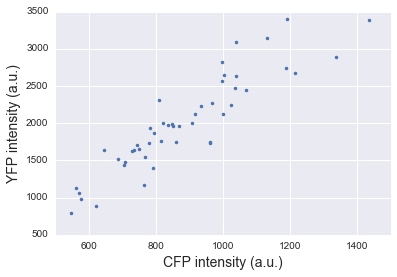

In [26]:
mean_c_intensity = np.empty(len(im_c_props))
mean_y_intensity = np.empty(len(im_y_props))
for i in range(len(im_c_props)):
    mean_c_intensity[i] = im_c_props[i].mean_intensity
    mean_y_intensity[i] = im_y_props[i].mean_intensity

intensityC3 = mean_c_intensity
intensityY3 = mean_y_intensity
# Plot intensities
plt.plot(mean_c_intensity, mean_y_intensity, '.')
plt.xlabel('CFP intensity (a.u.)')
plt.ylabel('YFP intensity (a.u.)');

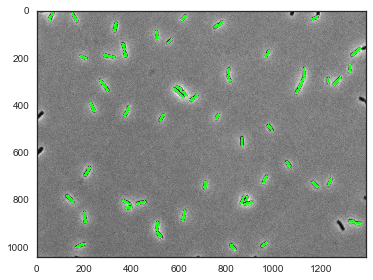

In [27]:
# Convert phase image to float RGB
im_p_float = (im_p - im_p.min()) / (im_p.max() - im_p.min())

# Make the green channel 1 wherever we have a bacterium
im_p_g = np.copy(im_p_float)
im_p_g[im_bw] = 1

# Build RGB image
im_p_rgb = np.dstack((im_p_float, im_p_g, im_p_float))

# Show result
with sns.axes_style('white'):
    skimage.io.imshow(im_p_rgb)


This is the representative segmentation for set 003. At last, we have done what is required of this part.

<div class='alert alert-info'> 
It looks like you only did this for a single image in each sample, which is why you have so few points in your plots. Ideally, you would write all of these steps into a single modular function and then just apply it to all of your image sets. 

<br />
7/10
</div> 

## 9.3 Part B##

Next, we analyze the correlation or lacktherof of the two different $\sigma$ factors. From the ReadMe file, we know that that data is as follows:

snaps001 : sigB-cfp, sigW-yfp, with constitutive RFP

snaps002 : sigB-cfp, sigB-yfp, with constitutive RFP

snaps003 : sigW-cfp, sigW-yfp, with constitutive RFP

From the above information, if we look at the scatter plot of cfp mean intensities vs. yfp mean intensities for snaps 001 and compare them to the like scatter plots of snaps 002 and 003, we can get a good indicator of the level of correlation. We would expect the absolute value of the correlation coefficients for snaps 002 and snaps 003 to be close to 1, because the same $\sigma$ factor in both are driving production of both cfp and yfp mRNA.

Let's first take a look at the scatterplot for scaps 002.

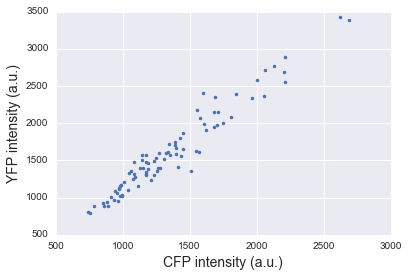

In [28]:
plt.plot(intensityC2, intensityY2, '.')
plt.xlabel('CFP intensity (a.u.)')
plt.ylabel('YFP intensity (a.u.)')

Now, we calculate the Pearson correlation coefficient from the data.

In [29]:
from scipy import stats

<div class='alert alert-info'> 
Import statements should **always** be in the document preamble.
</div>

In [32]:
stats.pearsonr(intensityC2, intensityY2)[0]

0.97033438161514896

Our correlation coefficient of 0.97033438161514896 is close to 1, suggesting a positive correlation which, as stated before, what we expect from this data given that the same $\sigma$ factor (sigB) is responsible for driving production of both CFP and YFP mRNA, which we quantify by looking at the intensities of the two channels.

<div class='alert alert-info'> 
You are reporting as many significant digits as you have data points. This is not something you should do. This is also a bit lacking for information because you have so few points. If you had processed all of the images, the correlation coefficient would have a deeper meaning. 
</div>

Let's see what we get for snaps 003 which portrays a similar situation. The same $\sigma$ factor is at play here for both channels, but this time sigW instead of sigB.

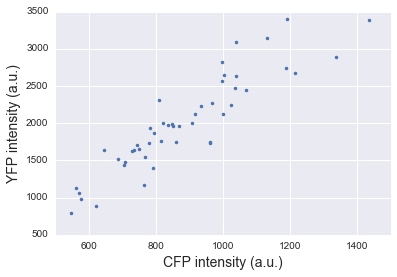

In [33]:
plt.plot(intensityC3, intensityY3, '.')
plt.xlabel('CFP intensity (a.u.)')
plt.ylabel('YFP intensity (a.u.)')

In [35]:
stats.pearsonr(intensityC3, intensityY3)[0]

0.90997141052739317

As expected, our Pearson correlation coefficient is high. 

Now, to determine how the sigB and sigW activities relate to each other (positively correlated, negatively correlated, or simply independent), we have to look at snaps 001. 

<div class='alert alert-info'> 
Anticorrelated is also an option.
</div>

Snaps 001 contains data responsible for sigB-cfp, sigW-yfp, with constitutive RFP. Unlike snaps 002 and snaps 003 shown above, in this case, we have DIFFERENT $\sigma$ factors at play, one each for each channel. Thus, by analyzing the scatter plot and correlation coefficient for snaps 001, we get an idea of the level of relation between the two factors, as desired.

Let's take a look at the plot for snaps 001.

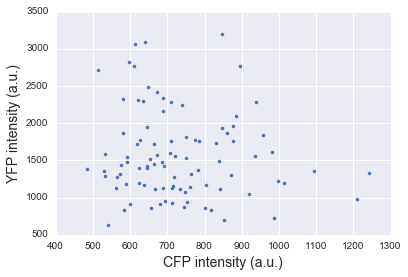

In [36]:
plt.plot(intensityC1, intensityY1, '.')
plt.xlabel('CFP intensity (a.u.)')
plt.ylabel('YFP intensity (a.u.)')

Just qualitatively looking at the plot and comparing it to the two plots above, we see that there is less correlation. The points appear to be more uniformly distributed across the grid, unlike the previous two plots where all points were essentially following a line. Now, let's get a qualitative estimate by getting the Pearson correlation coefficient.

In [37]:
stats.pearsonr(intensityC1, intensityY1)[0]

-0.10991684358553516

As expected, we get a correlation coefficient very close to 0. This suggests no linear relationship or a very weak linear relationship between the two channel intensities (which both relate to the corresponding sigma factors driving production of mRNA for cfp and yfp). Thus, in conclusion, based on the above plots and comparisons, we can hypothesize that sigB and sigW activities are likely independent of one another.

<div class='alert alert-info'> 
It's very hard to say based on the data you have, although I agree that it looks significantly less correlated. 
<br />
20/20
</div>